8/3/2021

Tighen L$_{2500}$-$\alpha_{ox}$ relationship by shifting points in the $\Gamma$-$\Delta\alpha_{ox}$ plane.  The first step will be shifting the distribution of $\Delta\alpha_{ox}$ in bins of $\Gamma$, and then we'll shift individual points based on their measured CIV distance.

In [1]:
#import necessary packages
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
from astropy.stats import sigma_clip
import matplotlib.mlab as mlab
import sys
sys.path.append("/Users/Trevor1/Desktop/git/CIV_Distance/") #wherever CIV distance repo is saved
from CIVfunctions import project,CIV_distance

#Default MPL colorcycle
mplcol = plt.rcParams['axes.prop_cycle'].by_key()['color']

Useful functions for plotting and shifting points around

In [14]:
def plot_contour(xdata, ydata, c="k", nlevels=3, ax=None, label=""):
    #Plot contours of dataset and all scatter points outside the contours
    if ax is None:
        ax = plt.gca()
    xmin, xmax = xdata.min(), xdata.max()
    ymin, ymax = ydata.min(), ydata.max()
    X, Y = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([xdata, ydata])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    
    #ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c)
    levels = ax.contour(X, Y, Z, levels=nlevels, linewidths=1.5, colors=c).levels
    
    for i in range(len(xdata)):
        #These are the indices of the ith's point location in Z (the density estimation) - probably the only tricky part about this
        xind = abs(X[:,0] - positions[0, abs(positions[0] - xdata[i]).argmin()]).argmin()
        yind = abs(Y[0,:] - positions[1, abs(positions[1] - ydata[i]).argmin()]).argmin()
        
        if Z[xind,yind] < levels[1]: #Plot the scatter point if it's below outermost contour level
            ax.scatter(xdata[i], ydata[i], color=c, s=10)#, label=label) #label only once
            
def even_fit(xdata, ydata):
    #Return the bisection of two fits on the same axes, but flipped
    m1,b1 = np.polyfit(ydata, xdata, 1)
    x1 = np.linspace(ydata.min(),ydata.max(),500)
    y1 = m1*x1 + b1
    
    m2,b2 = np.polyfit(xdata, ydata, 1)
    x2 = np.linspace(xdata.min(),xdata.max(),500)
    y2 = m2*x2 + b2
    
    xdata_clipped = sigma_clip(xdata, sigma=3, maxiters=10, masked=False)
    ydata_clipped = sigma_clip(ydata, sigma=3, maxiters=10, masked=False)
    clip_mask = ((xdata>=xdata_clipped.min()) & (xdata<=xdata_clipped.max())) & ((ydata>=ydata_clipped.min()) & (ydata<=ydata_clipped.max()))
    
    #Scale above data
    data = np.array([xdata[clip_mask], ydata[clip_mask]]).T
    fit1 = np.array([y1, x1]).T
    fit2 = np.array([x2, y2]).T
    
    #print(ydata_clipped.shape)
    scaler = MinMaxScaler().fit(data)
    data_scaled = scaler.transform(data)
    fit1_scale = scaler.transform(fit1)
    fit2_scale = scaler.transform(fit2)
    
    #Get point of intersection for two lines above
    intfit_x_scaled, intfit_y_scaled = line_intersection(fit1_scale, fit2_scale)

    #Get the slope splitting the angle between slopes in half
    m1_scale = lin_slope(fit1_scale)
    m2_scale = lin_slope(fit2_scale)

    phi = np.arctan((m1_scale-m2_scale)/(1+m1_scale*m2_scale))
    m_new_scaled = (m1_scale-np.tan(phi/2)) / (1+m1_scale*np.tan(phi/2))
    b_new_scaled = intfit_y_scaled - intfit_x_scaled*m_new_scaled
    x_new_scaled = np.linspace(data_scaled[:,0].min(), data_scaled[:,0].max(), 1000)
    y_new_scaled = m_new_scaled*x_new_scaled + b_new_scaled
    fit_new_scaled = np.array([x_new_scaled, y_new_scaled]).T

    #reverse back into normal coordinates
    fit_new = scaler.inverse_transform(fit_new_scaled)
    return fit_new
            
            
def lin_slope(line):
    #return slope of a linear fit
    return (line[1,1]-line[0,1])/(line[1,0]-line[0,0])

def line_intersection(line1, line2):
    #Get the x-y intersection of two line segments
    
    #Only care about the endpoints
    line1 = ( (line1[0,0], line1[0,1]), (line1[-1,0], line1[-1,1]) )
    line2 = ( (line2[0,0], line2[0,1]), (line2[-1,0], line2[-1,1]) )
    
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y


def project_pt(pt, fit):
    #Get location of a point's orthogonal projection onto a fit
    r2 = (pt[1]-fit[:,1])**2 + (pt[0]-fit[:,0])**2
    return np.array((fit[r2.argmin(),0], fit[r2.argmin(),1]))


def perp_distance(data, xax, yax):
    #Find the distance (with sign) of each point from the yaxis
        
    disty = []
    distx = []
    abs_disty = []
    abs_distx = []
    int_x, int_y = line_intersection(xax, yax) #intersection of the two new axes (the "origin")
    
    for i in range(len(data)):
        r_y = np.sqrt( (data[i,0] - yax[:,0])**2 + (data[i,1] - yax[:,1])**2 )
        r_x = np.sqrt( (data[i,0] - xax[:,0])**2 + (data[i,1] - xax[:,1])**2 )
        ind_yax = r_y.argmin()
        ind_xax = r_x.argmin()
        abs_disty.append(min(r_y)) ; abs_distx.append(min(r_x))
        
        #Get which side the of the line the point is on so we can have negative distances
        proj_x = project_pt(data[i,:], xax)
        side_y = 1 if (proj_x[0]>=int_x) else -1
        disty.append(side_y*min(r_y))
        
    return np.array(disty)

Load in full data from Rivera+2021, then cut it to only the clean objects and ones with x-ray measurements.

In [3]:
df = Table.read('AllXRayData_GTR.fits', format='fits')
dat = df.to_pandas()

print("Original Data: %d objects" % dat.shape[0])

#Take the clean objects that have available measurements
blue = dat["CIV_blue"].values
gamma = dat["Gamma"].values
daox  = dat["Delta_Alpha_ox"].values
clean = dat["Clean"].values
dat = dat[~np.isnan(blue)&~np.isnan(daox)&~np.isinf(gamma)&clean]

#Define vars in cut dataframe
gamma = dat["Gamma"].values
daox  = dat["Delta_Alpha_ox"].values
blue = dat["CIV_blue"].values
ew   = dat["CIV_EW"].values
logEW= np.log10(ew)
c4data = np.array([blue, logEW]).T
c4fit = np.load("/Users/Trevor1/Desktop/git/CIV_Distance/data/bestfit.npy")
CIVdist = CIV_distance(c4data, c4fit, step=10, path="/Users/Trevor1/Desktop/git/CIV_Distance/")

print("'Clean' Data: %d objects" % dat.shape[0])

dat.head()

Original Data: 5682 objects
'Clean' Data: 1067 objects


,SDSS,LOGEDD_RATIO,Gamma,f2keV_ergs,L2500,Alpha_ox,Delta_Alpha_ox,New_Delta_Alpha_ox,Delg-i,Timlin_CIV_EQW,...,LOGBH,Data_source,Clean,RA_1,DEC_1,Nardini_Sample,Good,CIV_Dist,CIV_Perp_Dist,XRayDist
0,b'SDSSJ015802.14-014839.7',NaN,2.02761,-31.806750,30.724800,-1.555219,-0.013984,-0.046999,-0.106000,NaN,...,NaN,4,True,29.508932,-1.811046,False,True,1.100772,0.078798,-0.371102
2,b'105403.28+545032.0 ',NaN,1.10000,-32.219419,30.208227,-1.682122,-0.243685,-0.275977,-0.061888,64.372035,...,NaN,1,True,163.513686,54.842229,False,False,1.042382,0.064972,0.359305
11,b'143218.64-011224.6 ',NaN,1.70000,-31.707645,30.680686,-1.612592,-0.080136,-0.113089,0.057048,54.096672,...,NaN,1,True,218.077681,-1.206861,False,True,1.039134,0.066717,-0.125253
15,b'143634.65+350553.8 ',NaN,1.50000,-32.007781,30.403632,-1.669932,-0.192610,-0.225175,0.147050,25.259747,...,NaN,1,True,219.144389,35.098291,False,False,1.023561,-0.066325,0.083601
17,b'100014.13+020054.4 ',-0.07,2.00000,-31.178440,30.859035,-1.491499,0.076449,0.043247,-0.181079,57.171472,...,8.7,1,True,150.058914,2.015134,False,True,0.975910,0.003419,-0.428053


Plot $\Gamma$ vs $\Delta\alpha_{ox}$ and colorcode points by CIV distance.  Most of the things we'll do in this notebook revolve around this plot.

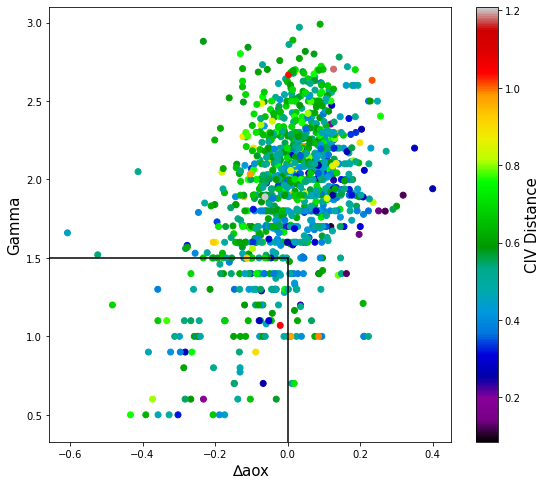

In [4]:
fig = plt.figure(figsize=(9,8))
plt.scatter(daox, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k") #Gordon - should this box be explained?
plt.plot([0,0],[ylims[0],1.5], "-k")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("∆aox", fontsize=15)
plt.show()

We can use the gradient in CIV distance to calibrate this relation.  

We can compute how much shift there is in $\Delta\alpha_{ox}$ in bins of $\Gamma$, and shift each

We don't know the absorption track for each individual object.  Instead we'll compute the mean of a sigma-clipped Gaussian fit to the distribution of CIV Distance in bins of $\Gamma$.  

In [5]:
#Create bins in gamma that will have equal number of objects in each
gamma_bins = [0.5] #start at the min
Nbin = 0 #increment

for Gamma in np.sort(gamma):
    Nbin += 1
    if Nbin%100==0:
        gamma_bins.append(Gamma)
gamma_bins.append(Gamma)
gamma_bins = np.array(gamma_bins)
gamma_bins[-1] = 3.

In [6]:
gamma_bins

array([0.5       , 1.29999995, 1.60000002, 1.70000005, 1.83684003,
       1.92528999, 2.01373005, 2.10581994, 2.20000005, 2.32219005,
       2.54708004, 3.        ])

In [7]:
np.sort(daox)

array([-0.60699164, -0.52345379, -0.48300295, ...,  0.31860924,
        0.35016023,  0.40011523])

In [8]:
sigma_clip?

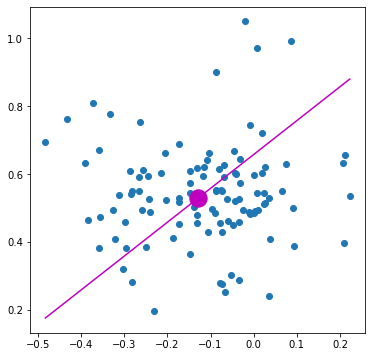

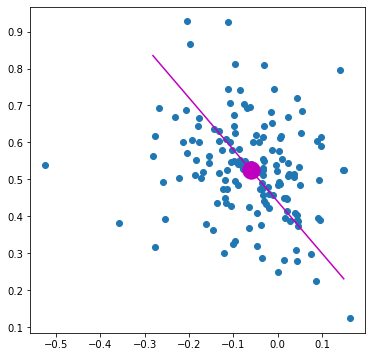

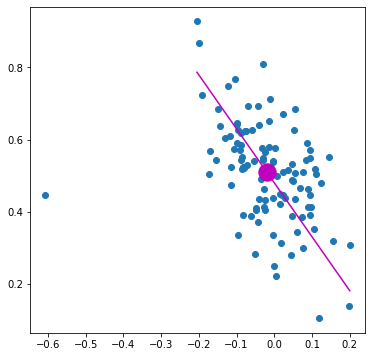

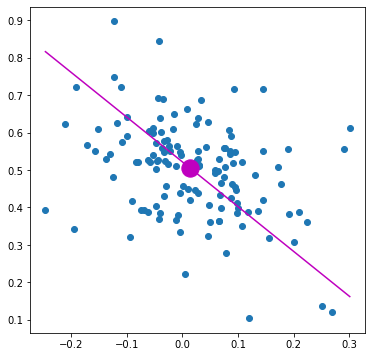

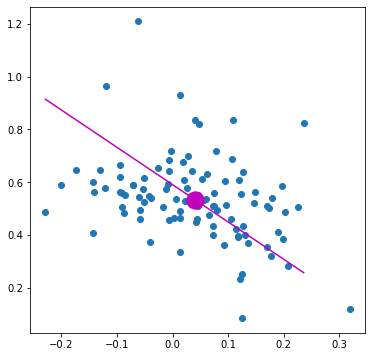

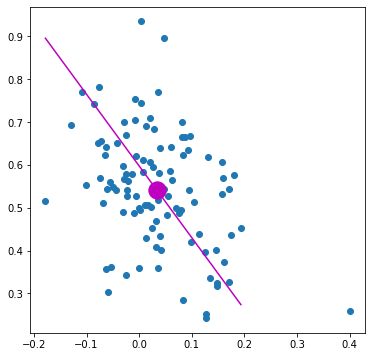

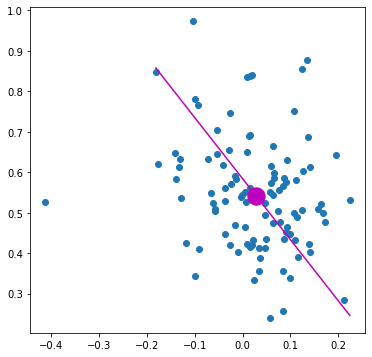

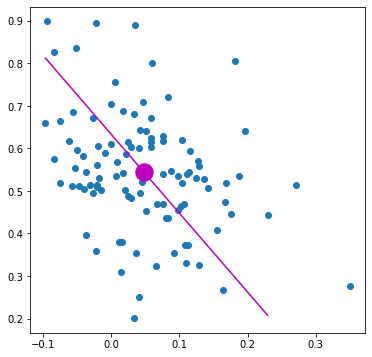

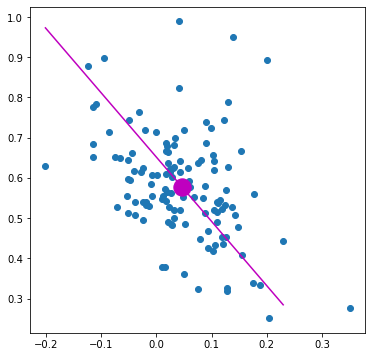

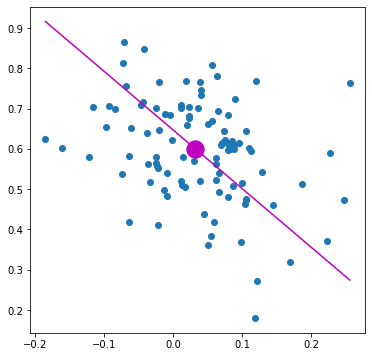

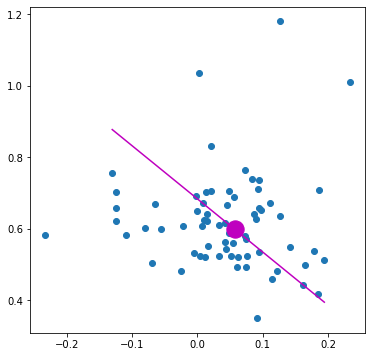

In [15]:
fit_bin_list = []
ind_mean_list = []

for i in range(len(gamma_bins)-1):
    binmask = ((gamma>=gamma_bins[i])&(gamma<=gamma_bins[i+1]))

    fit_bin = even_fit(daox[binmask], CIVdist[binmask]) ; fit_bin_list.append(fit_bin)

    #m_mcmc, b_mcmc = mcmc_fit2(daox[binmask], CIVdist[binmask], np.zeros(len(daox[binmask])), np.zeros(len(daox[binmask])))
    #x_mcmc = np.arange(-0.6, 0.4, 0.01) ; x_mcmc_list.append(x_mcmc)
    #y_mcmc = m_mcmc*x_mcmc + b_mcmc ; y_mcmc_list.append(y_mcmc)
    
    CIVdist_bin_clipped = sigma_clip(CIVdist[binmask], sigma_lower=3, sigma_upper=3, maxiters=10, masked=False)
    mu_civ = np.mean(CIVdist_bin_clipped)
    ind_mean = abs(fit_bin[:,1]-mu_civ).argmin() ; ind_mean_list.append(ind_mean)

    fig = plt.figure(figsize=(6,6))
    plt.scatter(daox[binmask], CIVdist[binmask])
    plt.plot(fit_bin[:,0], fit_bin[:,1], "-m")
    plt.scatter(fit_bin[ind_mean,0], fit_bin[ind_mean,1], c="m", s=300)
    plt.show()

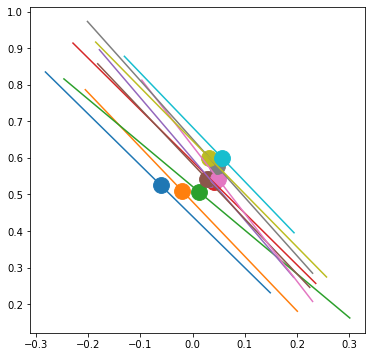

In [20]:
fig = plt.figure(figsize=(6,6))
for i in range(1, len(gamma_bins)-1):
    plt.plot(fit_bin_list[i][:,0], fit_bin_list[i][:,1])
    plt.scatter(fit_bin_list[i][ind_mean_list[i],0], fit_bin_list[i][ind_mean_list[i],1], s=250)
plt.show()

We're now  basically going to shift each of these fits along the x-axis so that they overlap.

In [18]:
mu_civ_list = []
for i in range(len(gamma_bins)-1):
    mu_civ_list.append(fit_bin_list[i][ind_mean_list[i],0])

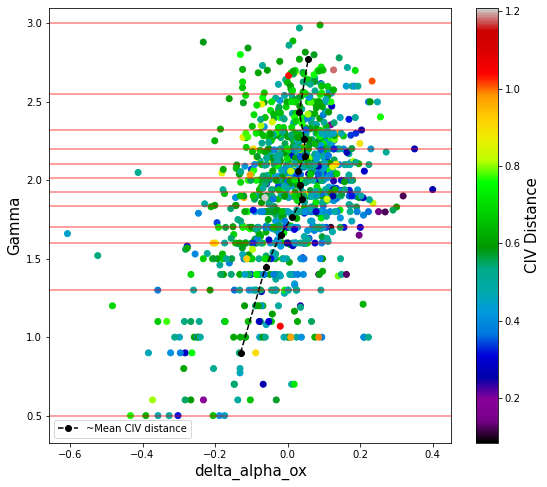

In [21]:
#Get the midpoints of the gamma bins to plot
gamma_bins_plot = np.zeros(len(gamma_bins)-1)
for i in range(len(gamma_bins)-1): gamma_bins_plot[i] = (gamma_bins[i]+gamma_bins[i+1])/2.

fig = plt.figure(figsize=(9,8))
plt.scatter(daox, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot(mu_civ_list, gamma_bins_plot, "--o", color="k", label="~Mean CIV distance")
#plt.plot(mu_civ_list, gamma_bins_plot, "--o", color="k", label="~Mean Daox")
#plt.plot(mu_civscale_list, gamma_bins_plot, "--o", color="m", label="~Mean CIV Distance")
#plt.plot(fit_meanciv[:,0], fit_meanciv[:,1], "-o", color="k", label="~Mean CIV Distance, fitted")

#Draw bin boundaries
for i in range(len(gamma_bins)): plt.plot(xlims, [gamma_bins[i], gamma_bins[i]], "-r", alpha=0.5)

cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.legend(loc="best")
plt.show()

Now that we're tracking CIV distance through the main plot, shift daox in each bin to the point closest to $\Delta\alpha_{ox}=0$

In [22]:
mu_civ_list

[-0.12966886522692533,
 -0.0604924357189551,
 -0.01953684684220621,
 0.012905244290510775,
 0.040457554397304626,
 0.03301987587111987,
 0.027729323126023813,
 0.04817857973277235,
 0.04645481853065716,
 0.0321986059663273,
 0.0567460975963636]

In [24]:
daox_ref = mu_civ_list[np.abs(mu_civ_list).argmin()]
daox_gamma = np.zeros(len(daox))

for i in range(len(gamma_bins)-1):
    binmask = ((gamma>=gamma_bins[i])&(gamma<=gamma_bins[i+1]))
    daox_gamma[binmask] = daox[binmask] + ( daox_ref - mu_civ_list[i] )

In [25]:
fit_bin_list_new = []
ind_mean_list_new = []

for i in range(len(gamma_bins)-1):
    binmask = ((gamma>=gamma_bins[i])&(gamma<=gamma_bins[i+1]))

    fit_bin = even_fit(daox_gamma[binmask], CIVdist[binmask]) ; fit_bin_list_new.append(fit_bin)
    
    CIVdist_bin_clipped = sigma_clip(CIVdist[binmask], sigma_lower=3, sigma_upper=3, maxiters=10, masked=False)
    mu_civ = np.mean(CIVdist_bin_clipped)
    ind_mean = abs(fit_bin[:,1]-mu_civ).argmin() ; ind_mean_list_new.append(ind_mean)

In [26]:
mu_civ_list_new = []
for i in range(len(gamma_bins)-1):
    mu_civ_list_new.append(fit_bin_list_new[i][ind_mean_list_new[i],0])

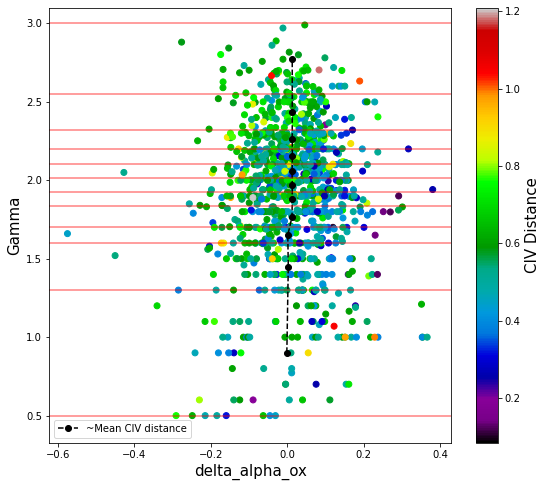

In [28]:
fig = plt.figure(figsize=(9,8))
plt.scatter(daox_gamma, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot(mu_civ_list_new, gamma_bins_plot, "--o", color="k", label="~Mean CIV distance")

#Draw bin boundaries
for i in range(len(gamma_bins)): plt.plot(xlims, [gamma_bins[i], gamma_bins[i]], "-r", alpha=0.5)

cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.legend(loc="best")
plt.show()

First shift done - now see how this affected aox vs L2500.

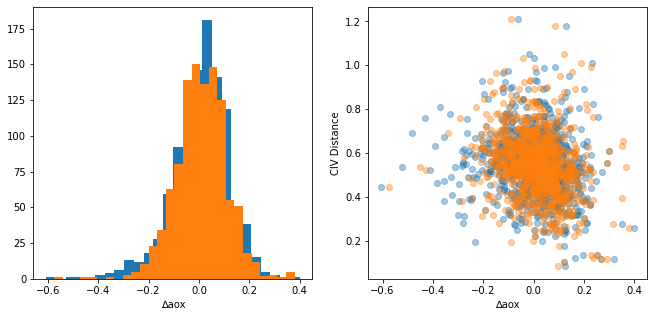

In [29]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11,5))

ax1.hist(daox, bins="scott", label="Original ∆aox")
ax1.hist(daox_gamma, bins="scott", label="Median-gamma shifted ∆aox")
ax1.set_xlabel("∆aox")

ax2.scatter(daox, CIVdist, alpha=0.4, label="Original ∆aox")
ax2.scatter(daox_gamma, CIVdist, alpha=0.4, label="Median-gamma shifted ∆aox")
ax2.set_xlabel("∆aox")
ax2.set_ylabel("CIV Distance")

plt.show()

Check new $\alpha_\mathrm{ox}$ vs. L2500

$$ \alpha_{ox,fit} = \alpha_{ox} - \Delta\alpha_{ox} $$

So the new $\alpha_{ox}$ value is 

$$ \alpha_{ox,new} = \alpha_{ox,old} - (\Delta\alpha_{ox,old} - \Delta\alpha_{ox,new}) $$

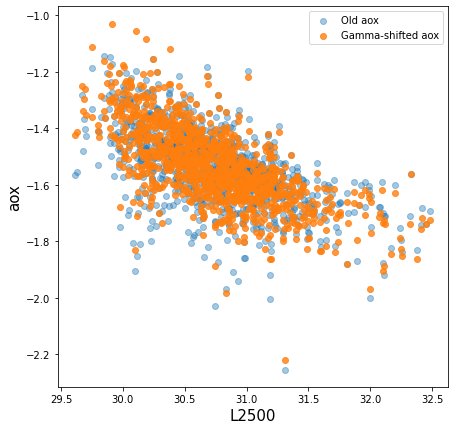

In [30]:
aox           = dat["Alpha_ox"].values #original aox values
aox_gamma     = aox - (daox - daox_gamma) #aox shifted based on gamma bins
L2500 = dat["L2500"].values

fig = plt.figure(figsize=(7,7))
plt.scatter(L2500, aox, alpha=0.4, label="Old aox")
plt.scatter(L2500, aox_gamma, alpha=0.8, label="Gamma-shifted aox")
plt.ylabel("aox", fontsize=15)
plt.xlabel("L2500", fontsize=15)
plt.legend(loc="best")
plt.show()

Not clear if first shift helped a whole lot, but we can now easily tighten this relation further by repeating the above process -- this time shifting points individually based on their CIV distance.

---

Define a new axis by fitting a line to the newly shifted Gamma vs daox data.

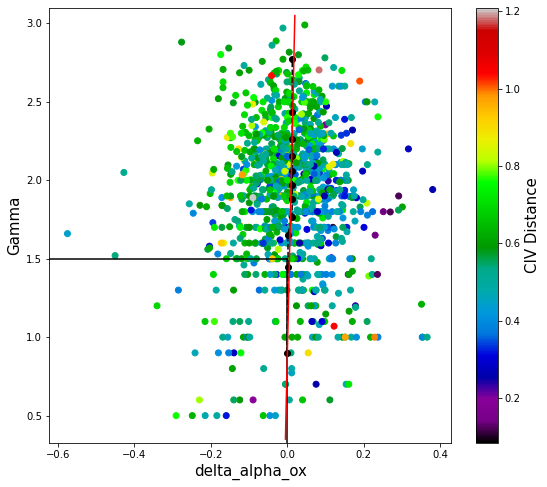

In [31]:
m_gamma, b_gamma = np.polyfit(gamma_bins_plot, mu_civ_list_new, 1)
x_gamma = np.linspace(0.35,3.05,1000)
y_gamma = m_gamma*x_gamma + b_gamma
fit_gamma = np.array([y_gamma,x_gamma]).T

fig = plt.figure(figsize=(9,8))
plt.scatter(daox_gamma, gamma, c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(mu_civ_list_new, gamma_bins_plot, "--o", color="k")
plt.plot(fit_gamma[:,0], fit_gamma[:,1], "-r")
#plt.plot(x,y,"-r")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.show()

We now need a fit of CIV distance vs distance from the red line above.  Then, based on each object's CIV distance, we'll shift it a given amount towards the red line.

Looping through each data point above, get the distance from the red line


First need to scale the data so we can compute orthogonal projections+distances in Gamma vs $\Delta\alpha_\mathrm{ox}$

In [32]:
def argmedian(data):
    return np.argsort(data)[len(data)//2]

yax = fit_gamma.copy()
indmed = argmedian(yax[:,1]) #get index where gamma is median - just for visual purposes
data_gamma = np.array([daox_gamma, gamma]).T

#Create and fit the scaler
scaler_gamma = MinMaxScaler().fit(data_gamma[data_gamma[:,1]<3.1]) #Max out scaler at 3.1
data_gamma_scale = scaler_gamma.transform(data_gamma)
yax_scale = scaler_gamma.transform(yax)

#Create a perpendicular axis in the scaled space
x_perp_scale = np.linspace(-.05, 1.05, 500)
m_gamma_perp_scale = -1 / lin_slope(yax_scale)
xi, yi = yax_scale[indmed,:]
b_gamma_perp_scale = yi - m_gamma_perp_scale*xi
xax_scale = np.array( [ x_perp_scale, m_gamma_perp_scale*x_perp_scale + b_gamma_perp_scale ] ).T

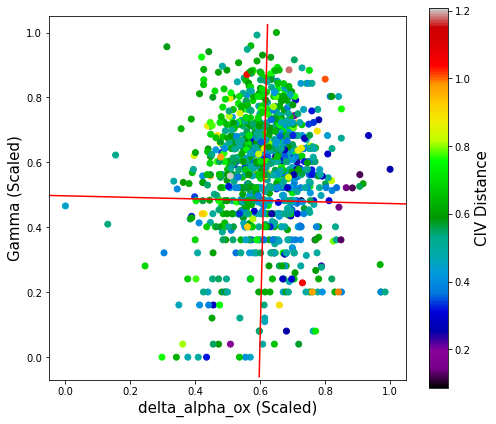

In [33]:
fig = plt.figure(figsize=(8,7))
plt.scatter(data_gamma_scale[:,0], data_gamma_scale[:,1], c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot(yax_scale[:,0], yax_scale[:,1], "-r")
plt.plot(xax_scale[:,0], xax_scale[:,1], "-r")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],1.05)
plt.xlim(xlims)
plt.ylabel("Gamma (Scaled)", fontsize=15)
plt.xlabel("delta_alpha_ox (Scaled)", fontsize=15)
plt.gca().set_aspect("equal")
plt.show()

Now that we have new x- and y-axes, we can determine distances from the scaled y-axis.  Note that the x-axis is just to determine which side of the y-axis each point is on.

The magnitude of point $i$'s distance from the new y-axis is given by:

$$ r_i = \min{ \sqrt{ ({\bf x_\mathrm{line}} - x_i)^2 + ({\bf y_\mathrm{line}} - y_i)^2 } } $$

By using the new x-axis as well, we can also project the point onto it -- then, if its x-value on the new x-axis is higher than the x-value of the point where the lines intersect, it is positive distance from the line.  Negative distance in the opposite scenario.

Get the distances from the new y-axis and plot against CIV distance; it looks like there should be a correlation.

In [34]:
dist_yax_scaled = perp_distance(data_gamma_scale, xax_scale, yax_scale)

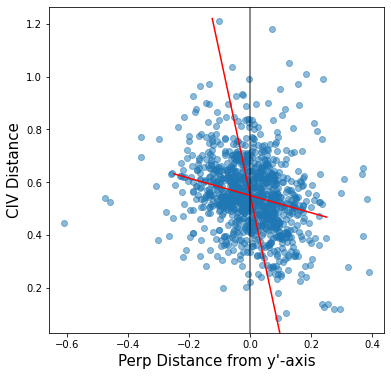

In [35]:
#Look at two fits - one of CIVdist vs distance from y' axis; another vice versa
m_civ,b_civ = np.polyfit(CIVdist, dist_yax_scaled, 1)
yrange_civ = np.linspace(0.02,1.22,500)
x_civ = m_civ*yrange_civ + b_civ

m_civ2,b_civ2 = np.polyfit(dist_yax_scaled, CIVdist, 1)
xrange_civ2 = np.linspace(-.25,.25,500)
y_civ2 = m_civ2*xrange_civ2 + b_civ2

fig = plt.figure(figsize=(6,6))
plt.scatter(dist_yax_scaled, CIVdist, alpha=0.5)
#plot_contour(dist_yax_scaled, CIVdist, c="b")
ylims = plt.gca().get_ylim()
plt.plot(x_civ, yrange_civ, "-r")
plt.plot(xrange_civ2, y_civ2, "-r")

plt.plot([0,0],[-0.1,1.5],"-k", alpha=0.6)
plt.ylabel("CIV Distance", fontsize=15)
plt.xlabel("Perp Distance from y'-axis", fontsize=15)
plt.ylim(ylims)
plt.show()

It looks like perp dist versus CIV distance gives a more favorable result, but both could be improved.  Get a fit that evenly bisects the two above. The angle made by two constant slopes is:

$$ \phi = \tan^{-1}(\frac{m_1-m_2}{1+m_1m_2}). $$

So the slope between the two is:

$$ \tilde{m} = \frac{m_1 - \tan(\phi/2)}{1+m_1\tan(\phi/2)} $$

In [36]:
#Scale above data
perp_civ_data = np.array([dist_yax_scaled, CIVdist]).T
fit_ydaox = np.array([x_civ, yrange_civ]).T
fit_yCIV = np.array([xrange_civ2, y_civ2]).T

scaler_civ = MinMaxScaler().fit(perp_civ_data)
perp_civ_data_scaled = scaler_civ.transform(perp_civ_data)
fit_ydaox_scale = scaler_civ.transform(fit_ydaox)
fit_yCIV_scale = scaler_civ.transform(fit_yCIV)

In [42]:
#Get point of intersection for two lines above
intfit_x_scaled, intfit_y_scaled = line_intersection(fit_yCIV_scale, fit_ydaox_scale)

#Get the slope splitting the angle between slopes in half
m1_scale = lin_slope(fit_yCIV_scale)
m2_scale = lin_slope(fit_ydaox_scale)

phi = np.arctan((m1_scale-m2_scale)/(1+m1_scale*m2_scale))
m_new_scaled = (m1_scale-np.tan(phi/2)) / (1+m1_scale*np.tan(phi/2))
b_new_scaled = intfit_y_scaled - intfit_x_scaled*m_new_scaled
x_new_scaled = np.linspace(0.50, 0.75, 1000)
y_new_scaled = m_new_scaled*x_new_scaled + b_new_scaled
fit_new_scaled = np.array([x_new_scaled, y_new_scaled]).T

#reverse back into normal coordinates
fit_new = scaler_civ.inverse_transform(fit_new_scaled)

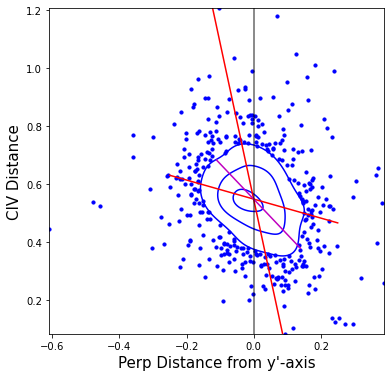

In [43]:
fig = plt.figure(figsize=(6,6))
#plt.scatter(dist_yax_scaled, CIVdist, alpha=0.5)
plot_contour(dist_yax_scaled, CIVdist, c="b")
ylims = plt.gca().get_ylim()
plt.plot(x_civ, yrange_civ, "-r")
plt.plot(xrange_civ2, y_civ2, "-r")
plt.plot(fit_new[:,0], fit_new[:,1], "-m")

plt.plot([0,0],[-0.1,1.5],"-k", alpha=0.6)
plt.ylabel("CIV Distance", fontsize=15)
plt.xlabel("Perp Distance from y'-axis", fontsize=15)
plt.ylim(ylims)
plt.show()

Now, given a point's CIV distance, what do we expect the perpendicular distance from the y'-axis to be (based on the magenta line)?  This is the distance towards zero we'll shift that point.  Note that using a longer magenta line causes large corrections for low/high CIV distance objects which we don't want.

The unit vector pointing along the orthogonal projection of the the point onto the curve gives the direction to shift:

$$ \hat{\bf r}_i = \frac{( x_\mathrm{line,proj} - x_i, y_\mathrm{line,proj} - y_i )}{r_i} $$

So if the original position of the data is ${\bf x}$, then its position along the new y axis ${\bf x}'$ is given by:

$$ {\bf x}' = {\bf x} + r_i\hat{\bf r}_i $$

In this, we'll fit for $r_i$ as a function of CIV distance.

In [44]:
def diag_shift(data, line, mag_shift):
    data_proj = project_pt(data, line)
    rvec = np.array((data_proj[0]-data[0], data_proj[1]-data[1]))
    rmag = np.linalg.norm(rvec)
    rhat = rvec / rmag
    return data + mag_shift*rhat

In [45]:
data_gamma_civ_scale = []
for i in range(len(CIVdist)):
    #Get index of the fitted CIV distance of point
    indperp = abs(CIVdist[i]-fit_new[:,1]).argmin()
    perpshift = fit_new[indperp,0]
    data_shifted = diag_shift(data_gamma_scale[i,:], yax_scale, abs(perpshift))
    data_gamma_civ_scale.append(data_shifted)
data_gamma_civ_scale = np.array(data_gamma_civ_scale)

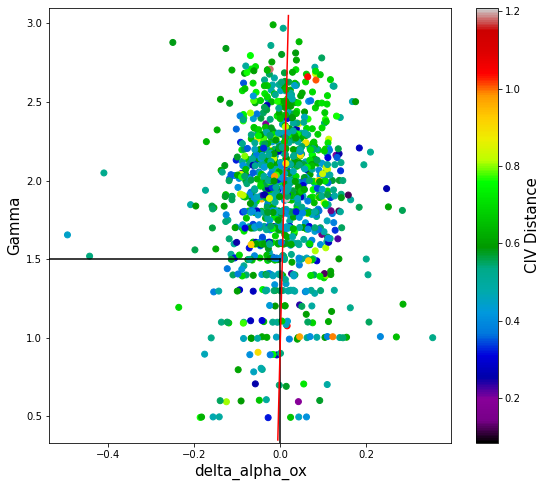

In [46]:
#Now inverse transform back into unscaled Gamma vs. ∆aox space
data_gamma_civ = scaler_gamma.inverse_transform(data_gamma_civ_scale)

fig = plt.figure(figsize=(9,8))
plt.scatter(data_gamma_civ[:,0], data_gamma_civ[:,1], c=CIVdist, cmap="nipy_spectral", edgecolor=None)
xlims, ylims = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.plot([xlims[0],0],[1.5,1.5], "-k")
plt.plot([0,0],[ylims[0],1.5], "-k")
plt.plot(fit_gamma[:,0], fit_gamma[:,1], "-r")
#plt.plot(x,y,"-r")
cbar = plt.colorbar()
cbar.ax.set_ylabel('CIV Distance', fontsize=15)
plt.ylim(ylims[0],3.1)
plt.xlim(xlims)
plt.ylabel("Gamma", fontsize=15)
plt.xlabel("delta_alpha_ox", fontsize=15)
plt.show()

The color gradient is not as strong anymore, so it looks like it worked.  Now check again the spread in $\Delta\alpha_\mathrm{ox}$ and L2500 vs. $\alpha_\mathrm{ox}$ to see if spread decreased

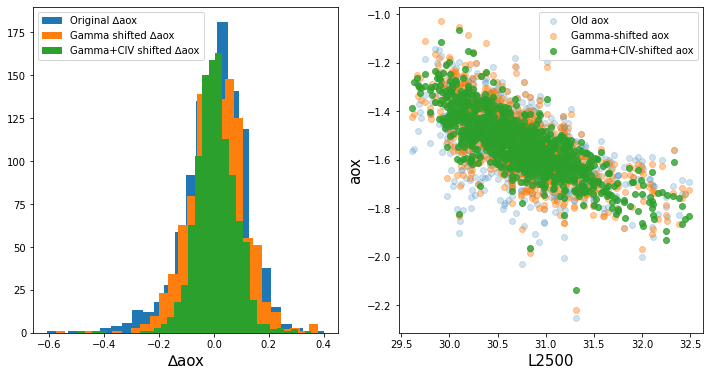

In [47]:
aox_gamma_civ = aox - (daox - data_gamma_civ[:,0]) #aox shifted based on gamma bins

fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(12,6))

ax1.hist(daox, bins="scott", label="Original ∆aox")
ax1.hist(daox_gamma, bins="scott", label="Gamma shifted ∆aox")
ax1.hist(data_gamma_civ[:,0], bins="scott", label="Gamma+CIV shifted ∆aox")
ax1.set_xlabel("∆aox", fontsize=15)
ax1.legend(loc="best")

ax2.scatter(L2500, aox, alpha=0.2, label="Old aox")
ax2.scatter(L2500, aox_gamma, alpha=0.4, label="Gamma-shifted aox")
ax2.scatter(L2500, aox_gamma_civ, alpha=0.8, label="Gamma+CIV-shifted aox")
ax2.set_ylabel("aox", fontsize=15)
ax2.set_xlabel("L2500", fontsize=15)
ax2.legend(loc="best")

plt.show()

Seems to have worked -- but are we still using $\Delta\alpha_\mathrm{ox}$ too much?

----

In [48]:
import emcee
from scipy.optimize import minimize

def log_likelihood(theta, x, y, xerr, yerr):
    m, b, log_disp = theta
    model = m*x + b
    sigma2 = xerr**2 + yerr**2 + np.exp(2*log_disp)
    return -1.0 * np.sum( ((y - model)**2 / sigma2) + np.log(sigma2) )

def log_prior(theta):
    m, b, log_disp = theta
    if -6 < m < 1 and -10. < b < 10. and np.log10(0.0001) < log_disp < np.log10(0.5):
        return 0.0
    return -np.inf

def log_probability(theta, x, y, xerr, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, xerr, yerr)

def mcmc_fit(x, y, xerr, yerr):
    #to plot on the flux grid
    x0 = np.linspace(x.min(), x.max(), 10)
    
    #First just find ML fit for MCMC initialization
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([0.9, -0.4, np.log(0.4)]) + 0.1 * np.random.randn(3)
    soln = minimize(nll, initial, args=(x, y, xerr, yerr))
    m_ml, b_ml, log_disp_ml = soln.x
    
    #Initalize and run MCMC
    pos = soln.x + 1e-4 * np.random.randn(32, 3)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, xerr, yerr))
    sampler.run_mcmc(pos, 5000, progress=True)
    
    #Remove the "burn-in" period
    tau = sampler.get_autocorr_time()
    flat_samples = sampler.get_chain(discard=int(2*np.mean(tau)), thin=15, flat=True)
        
    #Return gamma+uncertainties, dispersion
    return np.percentile(flat_samples[:, 0], [16, 50, 84]), np.exp(np.percentile(flat_samples[:, 2], [50]))

In [49]:
aox_params = mcmc_fit(L2500, aox, np.zeros(len(aox)), np.zeros(len(aox)))
aox_gamma_params = mcmc_fit(L2500, aox_gamma, np.zeros(len(aox_gamma)), np.zeros(len(aox_gamma)))
aox_gamma_civ_params = mcmc_fit(L2500, aox_gamma_civ, np.zeros(len(aox_gamma_civ)), np.zeros(len(aox_gamma_civ)))

100%|██████████| 5000/5000 [00:08<00:00, 591.53it/s]


In [50]:
aox_params, aox_gamma_params, aox_gamma_civ_params

((array([-0.16288763, -0.15796908, -0.15307576]), array([0.11166366])),
 (array([-0.19842869, -0.19390519, -0.18955268]), array([0.10095591])),
 (array([-0.19568629, -0.19247399, -0.18916624]), array([0.07452776])))

In [51]:
print("Parameters for fits above:\n")

print("Regular aox      : Slope = %.4f±%.4f, Dispersion = %.4f" % (aox_params[0][0], aox_params[0][1]-aox_params[0][0], aox_params[1][0]))
print("Gamma aox        : Slope = %.4f±%.4f, Dispersion = %.4f" % (aox_gamma_params[0][0], aox_gamma_params[0][1]-aox_gamma_params[0][0], aox_gamma_params[1][0]))
print("Gamma+CIVdist aox: Slope = %.4f±%.4f, Dispersion = %.4f" % (aox_gamma_civ_params[0][0], aox_gamma_civ_params[0][1]-aox_gamma_civ_params[0][0], aox_gamma_civ_params[1][0]))

Parameters for fits above:

Regular aox      : Slope = -0.1629±0.0049, Dispersion = 0.1117
Gamma aox        : Slope = -0.1984±0.0045, Dispersion = 0.1010
Gamma+CIVdist aox: Slope = -0.1957±0.0032, Dispersion = 0.0745


----

In [ ]:
#Get CIV distances from VLA/LOFAR
